**About BERTopic**

BERTopic was initially introduced in this [paper](https://doi.org/10.48550/arXiv.2203.05794).

BERTopic extends the idea of approaching topic modelling as a clustering task by using pre-trained transformer-based language models to embed each document.

More specifically, BERTopic generates document embedding with *pre-trained transformer-based language models*, clusters these embeddings using *UMAP* for dimensionality reduction and *HDBSCAN* to generate the clusters, and finally, generates topic representations with a *class-based TF-IDF* procedure.

**Running BERTopic on a GPU**

*BERTopic* offers GPU support by using the *cuml* package. However, this package can only be installed using the RAPIDS framework that requires itself an install through *conda* or *Docker*.
Please check the "Can I use the GPU to speed up the model?" section from the [BERTopic FAQ](https://maartengr.github.io/BERTopic/faq.html#how-can-i-run-bertopic-without-an-internet-connection) if you are interested in running the code below on your GPU.

In [1]:
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import plotly.io as pio
from bertopic import BERTopic

from tripadvisor_hotel_reviews_topic_modeling.bert_topic import BERTopicLabel
from tripadvisor_hotel_reviews_topic_modeling.data_processing import get_data

pio.renderers.default = "svg"  # needed for the plotly charts to render in github

/Users/anita.clementrvu.co.uk/Library/Caches/pypoetry/virtualenvs/tripadvisor-hotel-reviews-topic-modeling-VksP-CQw-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIR = Path().resolve().parent.joinpath("data")

In [3]:
df = get_data(
    dataset="andrewmvd/trip-advisor-hotel-reviews",
    filename="tripadvisor_hotel_reviews.csv",
)

In [4]:
df.columns = df.columns.str.lower()

In [5]:
label_dict = {1: "negative", 2: "negative", 3: "neutral", 4: "positive", 5: "positive"}
df["label"] = df["rating"].map(label_dict)

# 1. Data Exploration

In [6]:
df.head()

,review,rating,label
0,nice hotel expensive parking got good deal sta...,4,positive
1,ok nothing special charge diamond member hilto...,2,negative
2,nice rooms not 4* experience hotel monaco seat...,3,neutral
3,"unique, great stay, wonderful time hotel monac...",5,positive
4,"great stay great stay, went seahawk game aweso...",5,positive


## 1.1. Rating Distribution

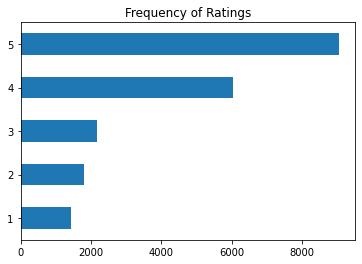

In [7]:
df["rating"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Ratings")
plt.show()

## 1.2. Reviews Length

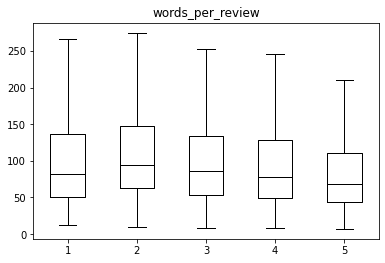

In [8]:
df["words_per_review"] = df["review"].str.split().apply(len)
df.boxplot("words_per_review", by="rating", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

For each rating most reviews are around 75-80 words long. 

# 2. BERTopic

In [ ]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)

# for label in df["label"].unique():
for label in ["positive", "negative"]:
    df_label = df.loc[df["label"] == label, "review"]
    df_label = df_label.reset_index(drop=True)
    topics_label, probs_label = topic_model.fit_transform(df_label)
    joblib.dump(topic_model, DATA_DIR.joinpath(f"./topic_model_{label}.pkl"))
    joblib.dump(topics_label, DATA_DIR.joinpath(f"./topics_label_{label}.pkl"))
    joblib.dump(probs_label, DATA_DIR.joinpath(f"./probs_label_{label}.pkl"))

## 2.1. Getting the topics for negative reviews

Not that in the following, topic -1 groups all the "outliers", the reviews that couldn't be assigned to a cluster.

The *BERTopicLabel* object also generates the topic model, topic labels and probs object from the seraliased file to avoid having to retrain each time the kernel gets restarted.

In [9]:
bert_topic_label = BERTopicLabel(label="negative", data=df)

In [10]:
bert_topic_label.get_number_topic()

'The total number of topics for the negative reviews is 42 for a total number of 3214 reviews.'

In [11]:
bert_topic_label.get_topn_topic_info(n_topic=10)

,Topic,Count,Name
0,-1,1490,-1_room_not_hotel_no
1,0,288,0_resort_punta_cana_not
2,1,131,1_hotel_rooms_room_small
3,2,102,2_juan_san_hotel_puerto
4,3,92,3_amsterdam_room_hotel_location
5,4,79,4_noise_noisy_hotel_street
6,5,78,5_barcelona_hotel_room_not
7,6,63,6_seattle_westin_hotel_room
8,7,56,7_food_service_not_resort
9,8,51,8_disappointed_hotel_disappointing_not


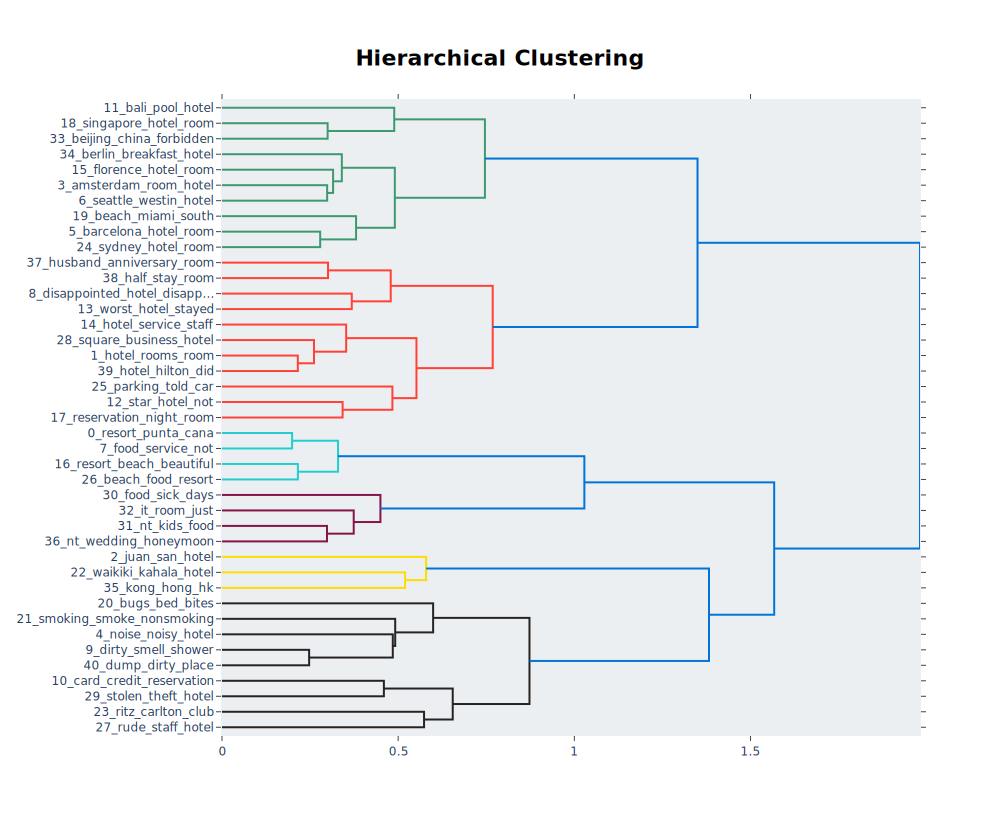

In [12]:
bert_topic_label.get_dendrogram()

From the dendrogram above, we could group our topics into 12 main topics (the 2 green ones, the 3 red ones, the 3 light blue ones, the 2 brown ones and the 2 yellow ones).

In [13]:
bert_topic_label.reduce_topic_number(n_topic=12)

We can now get the top 5 words for each topic to try to understand better what each topic is about! 

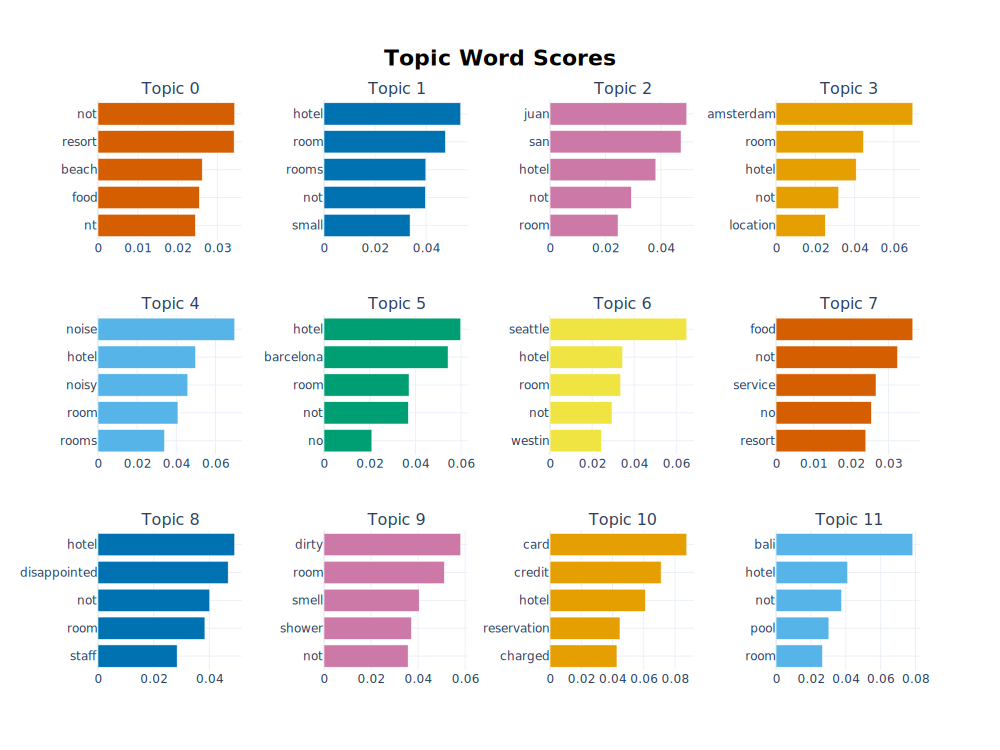

In [14]:
bert_topic_label.get_barchart_top5words_by_topic()

It seems that a lot of reviews were clustered by location (Amsterdam, Barcelona, etc.). 

We can try to give a name to each topic although it is not always clear from the top 5 words what it is really about. Looking at few examples from each topic could help.
- Topic 0: Room & Location
- Topic 1: Food & Beach
- Topic 2: San Juan & Room 
- Topic 3: Amsterdam & Room & Location
- Topic 4: Noise & Room
- Topic 5: Barcelona & Room
- Topic 6: Westin Seattle & Room
- Topic 7: Singapore & Hong Kong & Room
- Topic 8: Room & Disappointment
- Topic 9: Dirt & Smell & Room & Bathroom & Shower
- Topic 10: Food & Service
- Topic 11: Price & Booking

In [15]:
negative_reviews_predicted_topic = bert_topic_label.get_topic_review()

Batches: 100%|██████████| 101/101 [02:59<00:00,  1.77s/it]


In [16]:
bert_topic_label.get_sample_reviews_for_topic(
    topic_review_df=negative_reviews_predicted_topic, topic_nb=11, nb_reviews=3
)

bali garden o.k, family stayed bali garden hotel 7 days sure cremation site pool construction fine cheap holiday want pay right ahead, bali garden convenient staff friendly sure not standard oz not fussy just want great time,  

not good experience just recently 10 days holidays bali, stayed 4 nights villa puri ayu, spending 5 nights 2 villas seminyak say dissaponted villa puri ayu understatement, stayed emerald wing, granted price good soon enter room mosquitos buzzing room amazing, hundreds, everytime moved curtain 10 mosquitos fly, fumigate room emptying big bottle baygon left room couple hours, did trick night evidenced dead mosquitos floor morning mosquitos buzzing, everytime left room trip sprayed baygon rid mosquitos.water major problem, no hot water basin bathroom, trickle water showering hand held shower does n't work toilet got blocked second night, quick reception engineering team turned spent 45min unblocking toilet, finished left left piece s**t lying bathroom floor.other 

## 2.2. Getting the topics for positive reviews

In [17]:
bert_topic_label = BERTopicLabel(label="positive", data=df)

In [18]:
bert_topic_label.get_number_topic()

'The total number of topics for the positive reviews is 98 for a total number of 15093 reviews.'

In [19]:
bert_topic_label.get_topn_topic_info(n_topic=10)

,Topic,Count,Name
0,-1,4007,-1_not_resort_beach_room
1,0,1695,0_room_hotel_location_great
2,1,717,1_paris_metro_eiffel_hotel
3,2,717,2_barcelona_ramblas_hotel_metro
4,3,492,3_amsterdam_hotel_tram_canal
5,4,485,4_florence_hotel_italy_duomo
6,5,467,5_punta_cana_resort_beach
7,6,344,6_york_nyc_new_square
8,7,342,7_francisco_san_sf_union
9,8,338,8_seattle_downtown_pike_needle


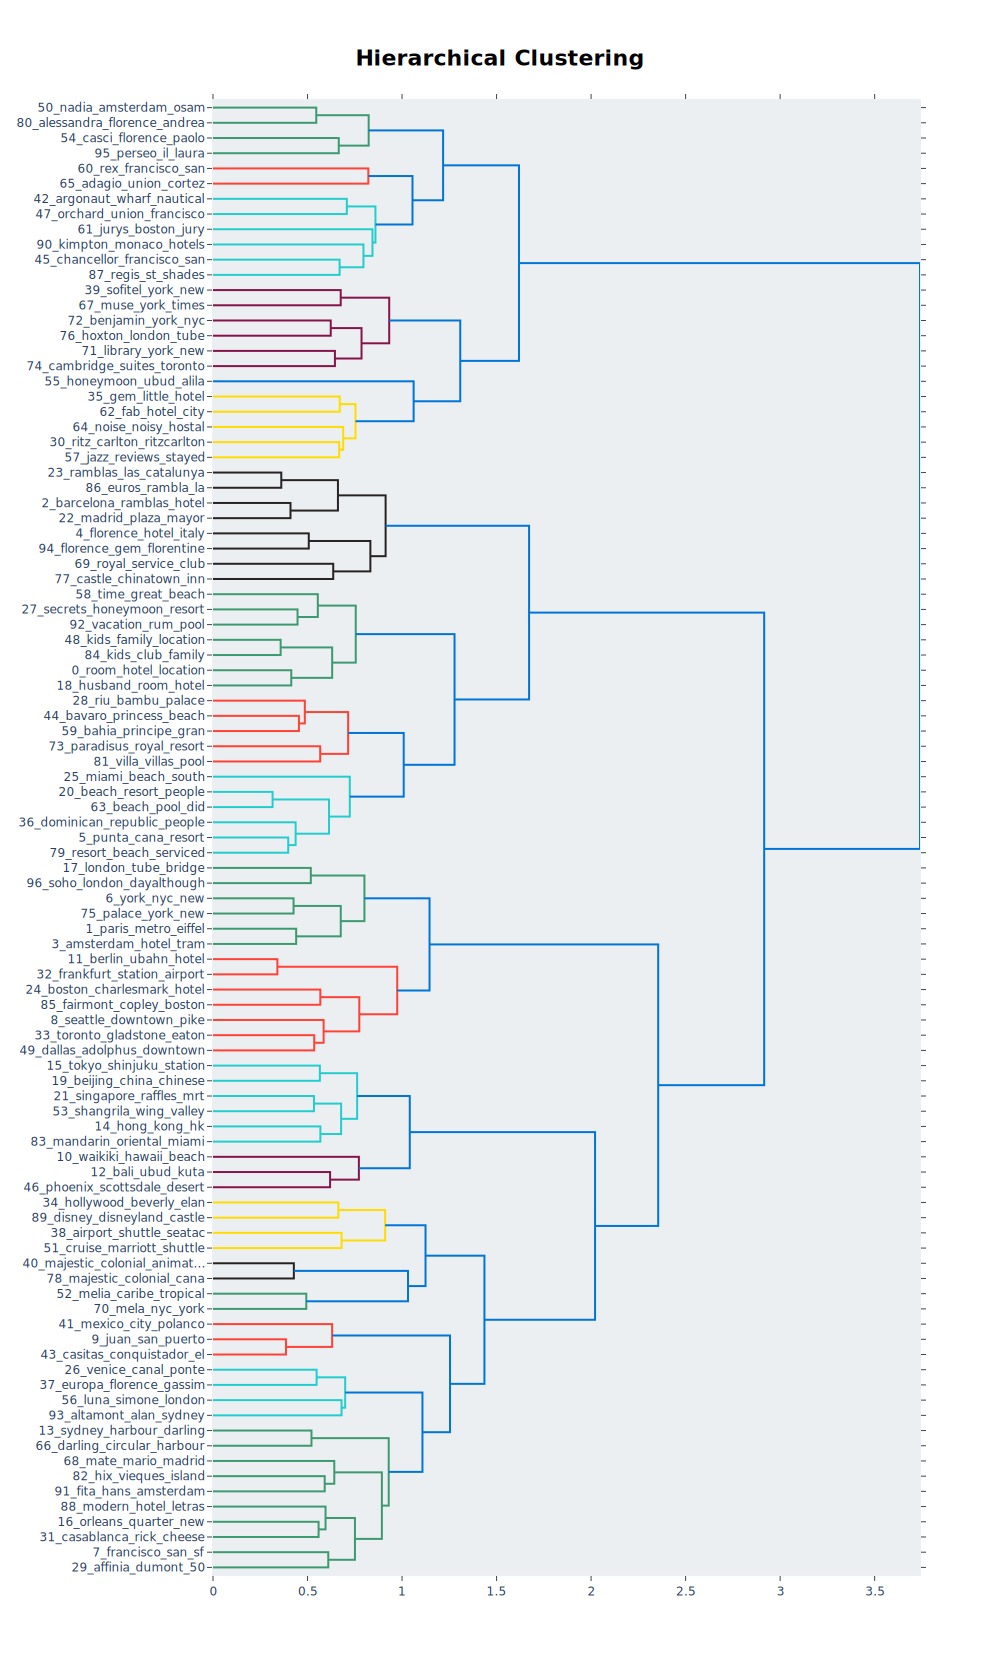

In [20]:
bert_topic_label.get_dendrogram()

In [21]:
bert_topic_label.reduce_topic_number(n_topic=13)

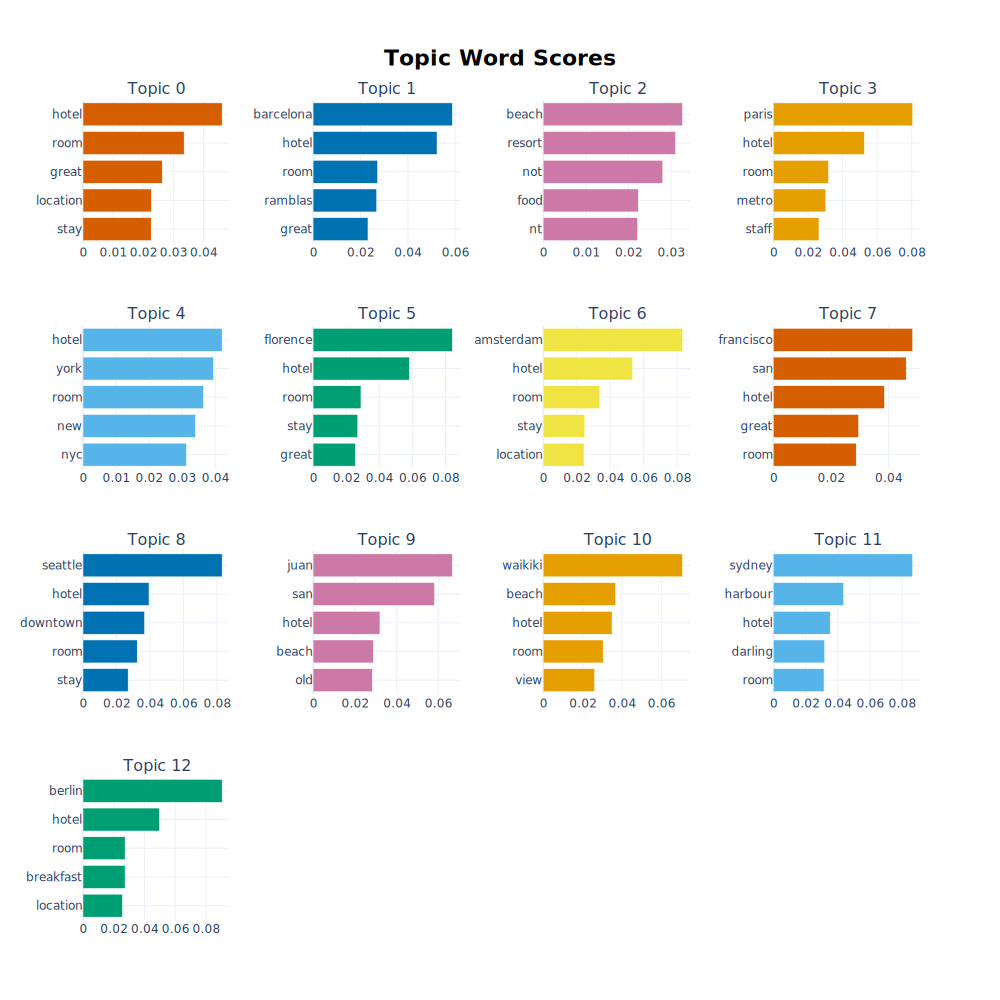

In [22]:
bert_topic_label.get_barchart_top5words_by_topic()

As for the negative reviews it seems that a lot of reviews were clustered by location (Barcelona, Paris, etc.). 

We can try to give a name to each topic although it is not always clear from the top 5 words what it is really about. Looking at few examples from each topic could help.
- Topic 0: Beach & Food
- Topic 1: Barcelona & Ramblas & Food
- Topic 2: Paris & Metro & Staff
- Topic 3: Florence & Breakfast
- Topic 4: NYC
- Topic 5: Amsterdam & Location
- Topic 6: New Orleans
- Topic 7: Location & Staff
- Topic 8: Seattle downtown
- Topic 9: San Francisco & Location
- Topic 10: Sydney & Harbour
- Topic 11: London & Tube & Breakfast
- Topic 12: Waikiki & Beach view

In [23]:
positive_reviews_predicted_topic = bert_topic_label.get_topic_review()

Batches: 100%|██████████| 472/472 [11:22<00:00,  1.45s/it]


In [24]:
bert_topic_label.get_sample_reviews_for_topic(
    topic_review_df=positive_reviews_predicted_topic, topic_nb=0, nb_reviews=3
)

nice buffet amazing, hotel pretty far old ghurka camp location travel hk nimps,  

love, just returned days happy report loved, parking real plus garage right hotel entrance elevators, able fetch things left car store things picked day no problem, valet gentlemen nice friendly accommodating- especially cuba, appreciated filtered water spout bathroom daily times-picayune not generic usa today paper marvelous breakfast- recently added make-your-own fresh waffles great, complaint fairly petty- place use little freshening up- paint scrapes elevators worn stained carpets really important plenty brand-new generic chain hotels, bayona literally street arnaud broussard just corner ca n't beat location, definitely return,  

friendly clean excellent small boutique hotel minutes walk eiffel tour, wonderful breakfast decent prices minibar items, extremely clean safe enviroment updated rooms, lots shops markets 2 block radius, stayed 2 year olds week staff n't friendly boys, price amazing quality 